In [152]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.stats as stats
import branch_kernParamGPflow as bk

# Load and plot the single cell qPCR data

In [2]:
# get the data
import pods, pandas as pd
data = pods.datasets.singlecell()
genes = data['Y']
labels = data['labels']
label_dict = dict(((i,l) for i,l in enumerate(labels)))
#print label_dict
N = genes.shape[0]
G = genes.shape[1]
genes.describe()

,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
count,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,...,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02
mean,2.089245e-08,2.400458e-08,3.011442e-08,2.009153e-08,1.416476e-08,2.661327e-08,1.828375e-08,2.329519e-08,2.993135e-08,2.077803e-08,...,2.180778e-08,2.146453e-08,2.077803e-08,2.585812e-08,2.473684e-08,2.670481e-08,2.009153e-08,2.231121e-08,2.263158e-08,2.606407e-08
std,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,...,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00,1.001146e+00
min,-2.997659e+00,-2.140030e+00,-1.768643e+00,-2.355953e+00,-4.420191e+00,-1.972546e+00,-2.493296e+00,-2.290915e+00,-1.641875e+00,-1.755517e+00,...,-2.246728e+00,-2.015028e+00,-2.960914e+00,-1.964500e+00,-2.033562e+00,-1.886886e+00,-2.238215e+00,-2.089612e+00,-1.825355e+00,-2.035440e+00
25%,-7.169942e-01,-7.796685e-01,-7.171038e-01,-9.337937e-01,-2.516838e-01,-6.446426e-01,-7.717112e-01,-8.545864e-01,-6.703301e-01,-1.018770e+00,...,-7.734272e-01,-9.343944e-01,-6.515803e-01,-7.255418e-01,-7.276985e-01,-8.376303e-01,-9.886838e-01,-9.197137e-01,-9.236930e-01,-7.673579e-01
50%,9.227372e-02,-1.782182e-01,-1.842611e-01,2.928931e-01,2.146358e-01,-1.353097e-01,2.772327e-01,-6.806050e-02,-2.415102e-01,1.097815e-01,...,7.709900e-03,8.293864e-02,-3.701860e-02,-1.972392e-01,-1.336842e-01,-2.656403e-01,2.828122e-01,-1.836380e-02,-1.127644e-01,-2.462695e-01
75%,6.808323e-01,6.245760e-01,3.312916e-01,8.234601e-01,6.738631e-01,4.854397e-01,8.213037e-01,9.125241e-01,4.854736e-01,9.259312e-01,...,8.608111e-01,8.312436e-01,6.177259e-01,1.082358e+00,5.329677e-01,9.967453e-01,8.099583e-01,1.022974e+00,8.257577e-01,6.422915e-01
max,2.490650e+00,3.564713e+00,2.627702e+00,1.687127e+00,1.569268e+00,3.427747e+00,1.826346e+00,1.729923e+00,2.780331e+00,1.671790e+00,...,1.709987e+00,4.489121e+00,3.565258e+00,1.655467e+00,2.231074e+00,2.104293e+00,4.187598e+00,1.808619e+00,2.208022e+00,2.270316e+00


In [3]:
D = genes.shape[1]
N = genes.shape[0]
stageCell = np.zeros(N)
stageN = np.zeros(N)
for i,l in enumerate(labels):
    stageCell[i] = int(l[:2])
    stageN[i] = np.log2(stageCell[i]) + 1
    
captureTimes=stageCell[:,None]

# GPFlow 

In [4]:
import GPflow
class GPLVM(GPflow.gpr.GPR):
    def __init__(self, X, Y, kern, mean_function):
        GPflow.gpr.GPR.__init__(self, X, Y, kern, mean_function)
        self.X = GPflow.param.Param(self.X)


In [82]:
T=genes.values

idxEarly = np.logical_or(np.logical_or(np.logical_or(np.logical_or(np.logical_or(captureTimes[:,0] == 1,captureTimes[:,0] == 2),\
        captureTimes[:,0] == 4),captureTimes[:,0] == 8),captureTimes[:,0] == 16),captureTimes[:,0] == 32)

#idxEarly = np.array(range(T.shape[0]))

Tearly = T[idxEarly,:]
labelsEarly = labels[idxEarly]
stageNEarly = stageN[idxEarly]
Nearly = Tearly.shape[0]
print Tearly.shape

(278, 48)


In [128]:
# generate true labels
strLabels = labels[idxEarly]
labelsX = np.ones( (Tearly.shape[0],1) )
for i,l in enumerate(strLabels):
    if l == '32 ICM':
        labelsX[i] = 2
    elif l == '32 TE':
        labelsX[i] = 3
np.unique(labelsX)

array([ 1.,  2.,  3.])

In [151]:
stageNEarly[200]

6.0

In [150]:
labelsEarly[200]

'32 ICM'

In [91]:
# linear GPLVM
m = GPLVM(np.random.randn(Nearly, 2), Tearly, GPflow.kernels.Linear(2), mean_function=GPflow.mean_functions.Constant(np.zeros(D)))

m.likelihood.variance = 0.1
m.likelihood.variance.fixed = True

# Set the prior
muPrior = np.vstack([stageNEarly, np.zeros(Nearly)]).T
#muPrior = np.vstack([np.zeros(Nearly), np.zeros(Nearly)]).T


varPrior = np.vstack([0.5*np.ones(Nearly), np.ones(Nearly)]).T

m.X.prior = GPflow.priors.Gaussian(muPrior,varPrior)

In [92]:
m.optimize()

compiling tensorflow function...
done
optimization terminated, setting model state


      fun: array([ 28751.58695439])
 hess_inv: <605x605 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.81314095e-02,  -2.33926736e-02,  -3.27572092e-02,
        -5.46122981e-02,   5.70104767e-04,  -2.41745411e-02,
        -6.67040893e-03,  -7.71425237e-03,  -1.92771032e-02,
        -5.23540783e-02,  -3.29755972e-02,   2.65469837e-02,
         6.77266140e-02,  -2.26412553e-02,   2.14023230e-02,
         2.81314074e-02,   1.04889052e-02,   1.92255196e-02,
         1.06795693e-02,  -1.09923886e-02,  -8.84707914e-03,
         2.59607045e-02,   1.48864398e-02,  -6.17572254e-02,
         4.14788855e-02,   2.33264986e-02,   7.98682091e-03,
        -2.43621912e-02,  -7.37210234e-03,  -1.12562622e-02,
         8.80027503e-03,  -3.06016020e-02,   1.31832048e-02,
         2.65044557e-02,  -1.98587659e-02,   7.51242213e-03,
         4.10001480e-02,   9.56575995e-03,   4.13863364e-02,
         2.11120399e-02,  -1.25690081e-02,  -1.09609621e-03,
        -5.93105849e-02,   1.22880759e-

Spearman R=0.77 p=0.00000


Name,values,prior,constriant
kern.variance,[ 0.8681898],None,+ve


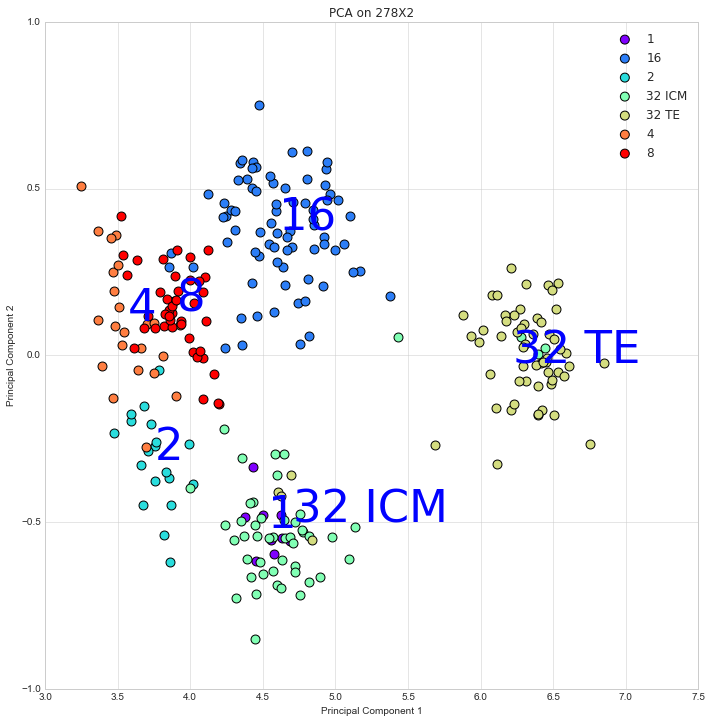

In [93]:
def plot(Y,labelParam):
    # plot PCA on first two principal components
    strLabels = labelParam.values
    uniqueLabels = np.unique(strLabels)
    import matplotlib.cm as cm
    colors = cm.rainbow(np.linspace(0, 1, len(uniqueLabels)))
    Dlatent = 2
    with plt.style.context('seaborn-whitegrid'):
            plt.figure(figsize=(10, 10))
            for lab,c in zip(uniqueLabels,colors):
                y1 = Y[strLabels==lab, 0]
                if(Dlatent == 2):
                    y2 = Y[strLabels==lab, 1]
                else:
                    y2 = y1

                plt.scatter(y1,
                            y2,
                            label=lab,
                            c=c,s=80)
                if(Dlatent == 2):
                    plt.text(np.mean(y1),np.mean(y2),lab, fontsize=45, color='blue')
                else:
                    plt.text(np.max(y1),np.max(y2),lab, fontsize=15, color='blue')
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.title('PCA on %gX%g'%Y.shape)
    
plot(m.X._array, labelsEarly)
print 'Spearman R=%.2f p=%.5f'%stats.spearmanr(stageNEarly, m.X._array[:,0])
m.kern

# Initialisation for hierarchical model
1. PCA to Gene to 2-D - does not need to use capture times. 
1. 2-D to 1-D (t)
1. Plotting smoothing curves per cluster.

In [94]:
import GPflow
import tensorflow as tf
class Deep(GPflow.model.Model):
    def __init__(self, Y, k1, k2, T0, X0, mf1=None, mf2=None):
        GPflow.model.Model.__init__(self)
        self.k1 = k1
        self.k2 = k2
        self.T = GPflow.param.Param(T0)
        self.X = GPflow.param.Param(X0)
        self.Y = Y

        if mf1 is None:
            mf1 = GPflow.mean_functions.Zero()
        if mf2 is None:
            mf2 = GPflow.mean_functions.Zero()
        self.mf1, self.mf2 = mf1, mf2

    def build_likelihood(self):

        # p(X | T)
        K1 = self.k1.K(self.T)
        L1 = tf.cholesky(K1)
        m1 = self.mf1(self.T)
        l = GPflow.densities.multivariate_normal(self.X, m1, L1)

        # p(Y | X, T)
        X_and_T = tf.concat(1, [self.T, self.X])
        K2 = self.k2.K(X_and_T)
        L2 = tf.cholesky(K2)
        m2 = self.mf2(self.T)
        l += GPflow.densities.multivariate_normal(self.Y, m2, L2)

        return l
    
    @GPflow.model.AutoFlow(tf.placeholder(tf.float64, [None, None]))
    def predict_1(self, Xnew):
        
        full_cov = False
        
        Kx = self.k1.K(self.T, Xnew)
        K = self.k1.K(self.T)
        L = tf.cholesky(K)
        A = tf.matrix_triangular_solve(L, Kx, lower=True)
        V = tf.matrix_triangular_solve(L, self.X - self.mf1(self.T), lower=True)
        fmean = tf.matmul(tf.transpose(A), V) + self.mf1(Xnew)
        if full_cov:
            fvar = self.k1.K(Xnew) - tf.matmul(tf.transpose(A), A)
            fvar = tf.tile(tf.expand_dims(fvar, 2), tf.pack([1, 1, tf.shape(self.X)[1]]))
        else:
            fvar = self.k1.Kdiag(Xnew) - tf.reduce_sum(tf.square(A), reduction_indices=0)
            fvar = tf.tile(tf.reshape(fvar, (-1,1)), tf.pack([1, tf.shape(self.X)[1]]))
        return fmean, fvar
        
        

In [164]:
#k1 = GPflow.kernels.Matern52(1) + GPflow.kernels.White(1, variance=0.1) # T->X
import BranchingTree as bt
tree = bt.BinaryBranchingTree(0,100,fDebug=False) # set to true to print debug messages
tree.add(None,1,10) # single branching point
(fm, _) = tree.GetFunctionBranchTensor()
    
BvaluesInit = 5*np.ones((1,1)) # split at around capture time 5
k1 = bk.BranchKernelParam(GPflow.kernels.Matern32(1), fm, BvInitial=BvaluesInit) + GPflow.kernels.White(1)
k1.branchkernelparam.Bv.fixed = True
    
k2 = GPflow.kernels.Linear(2) + GPflow.kernels.White(2, variance=0.1) # X,T->Y

#k1.rbf.variance.fixed = True
#k1.matern52.lengthscales.fixed = True
#k1.white.variance.fixed = True
k1.white.variance.prior =  GPflow.priors.Gaussian(1,0.001)
muPrior = stageNEarly[:,None]
varPrior = 2.*np.ones(Nearly)[:,None]

T0 = np.hstack([m.X._array[:,0:1], labelsX])
print 'T0=' + str(T0.shape)
md = Deep(Tearly, k1=k1, k2=k2, T0=T0, X0=m.X._array[:,1:2], mf2=GPflow.mean_functions.Constant(np.zeros(D)))

md.T.prior = GPflow.priors.Gaussian(muPrior,varPrior)

T0=(278, 2)


In [205]:
md.T._array

array([[ 4.37349136,  1.        ],
       [ 4.33254171,  1.        ],
       [ 4.66416805,  1.        ],
       [ 4.52735056,  1.        ],
       [ 4.4605827 ,  1.        ],
       [ 4.60712858,  1.        ],
       [ 4.54785428,  1.        ],
       [ 4.58718231,  1.        ],
       [ 4.42540124,  1.        ],
       [ 3.78023469,  1.        ],
       [ 3.57327166,  1.        ],
       [ 3.90979949,  1.        ],
       [ 3.66539799,  1.        ],
       [ 3.94951525,  1.        ],
       [ 3.61927541,  1.        ],
       [ 3.80136142,  1.        ],
       [ 3.75369077,  1.        ],
       [ 3.67534408,  1.        ],
       [ 3.67405084,  1.        ],
       [ 3.67701385,  1.        ],
       [ 3.75531131,  1.        ],
       [ 3.80974002,  1.        ],
       [ 3.63400898,  1.        ],
       [ 3.60148101,  1.        ],
       [ 3.48624378,  1.        ],
       [ 3.5768134 ,  1.        ],
       [ 3.4836722 ,  1.        ],
       [ 3.36981214,  1.        ],
       [ 3.54875299,

In [165]:
md.optimize(max_iters=1000)

compiling tensorflow function...
done
optimization terminated, setting model state


      fun: array([ 48981.87873454])
 hess_inv: <887x887 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.82049321e+00,  -3.47390029e+00,   7.90623689e+01,
         2.17083516e+01,  -4.11160879e+04,  -1.42634655e+02,
         3.59480947e+01,  -6.05797725e+01,  -2.20742099e+02,
         1.92144012e+02,  -1.35361446e+02,   1.51722388e+02,
         1.35073629e+02,  -2.80646716e+02,  -1.96790323e+02,
        -9.43103521e+01,   2.68420708e+02,   3.15893829e+02,
        -2.56138218e+01,   2.87669839e+02,   1.42634651e+02,
        -2.34518196e+02,   2.63964216e+02,   4.64720367e+01,
         2.04974739e+01,   1.21154197e+02,   2.23859198e+02,
         2.11954864e+02,  -2.64481048e+02,   2.38784735e+02,
         1.95287939e+02,  -3.37939090e+01,  -2.39564146e+02,
        -1.97458875e+02,   3.02983379e+01,  -2.78135511e+01,
        -1.54149948e+02,   1.26991087e+02,  -1.23594820e+02,
         2.60815071e+02,   2.98051976e+02,   8.11607740e+01,
        -6.26646962e+01,   2.60373235e+

In [172]:
np.max(md.T._array,axis=0)

array([ 6.8990227,  3.       ])

In [187]:
xnew = np.linspace(3,7,100)
lnew = np.ones_like(xnew)
lnew[xnew > 5] = 2
xnew2 = np.linspace(5,7,30)
lnew2 = 3*np.ones_like(xnew2)

a = np.vstack([xnew,lnew]).T
b = np.vstack([xnew2,lnew2]).T
b
Xnew = np.vstack([a,b])

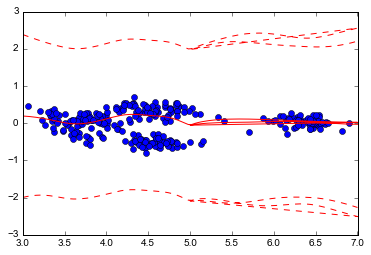

In [192]:
plt.plot(md.T._array[:,0], md.X._array, 'o')
md._needs_recompile = True
[mp,vp] = md.predict_1(Xnew)
plt.plot(Xnew[:,0], mp, '-r' )
plt.plot(Xnew[:,0], mp+2*np.sqrt(vp), '--r' )

plt.plot(Xnew[:,0], mp-2*np.sqrt(vp), '--r' )

In [193]:
md.X._array.shape

(278, 1)

In [194]:
md.k1

Name,values,prior,constriant
k1.branchkernelparam.kern.variance,[ 1.],None,+ve
k1.branchkernelparam.kern.lengthscales,[ 1.],None,+ve
k1.branchkernelparam.Bv,[[ 5.]],None,[FIXED]
k1.white.variance,[ 1.],"N([ 1.],[ 0.001])",+ve


In [195]:
md.k2

Name,values,prior,constriant
k2.linear.variance,[ 1.],None,+ve
k2.white.variance,[ 0.1],None,+ve


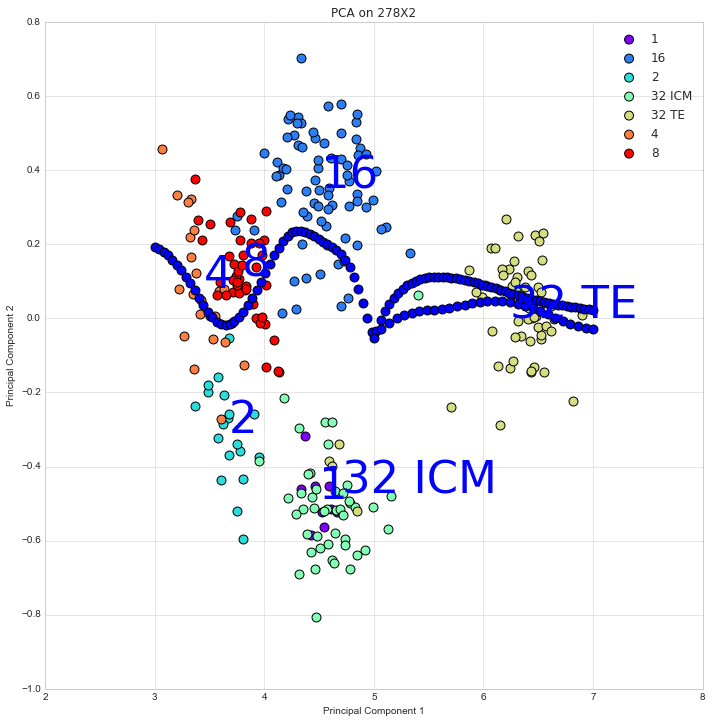

In [202]:
plot(np.hstack([md.T._array[:,0:1],md.X._array]), labelsEarly)
plt.scatter(Xnew[:,0], mp, s=80 )